In [1]:

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

import numpy as np
#import matplotlib.pyplot as plt
import torch

import defmod as dm
import defmod.multimodule_usefulfunctions as mm

torch.set_default_tensor_type(torch.DoubleTensor)

In [2]:
nb_pts1 = 7
dim = 2

o1 = torch.tensor([-1.,0.])
o2 = torch.tensor([-1.,0.])
origin = [o1,o2]
r1 = 2
r2 = 1
radius = [r1, r2]
nb_pts = [nb_pts1, nb_pts1]
source = mm.multipleCircles(origin, radius, nb_pts)


manifold = dm.manifold.Landmarks(dim, nb_pts1, gd=source[0].view(-1))

#scal = dm.deformationmodules.LocalScaling(manifold, sigma)
sigma = 1.
scal = dm.deformationmodules.GlobalScaling(manifold, sigma)


In [3]:
scal.manifold.gd, scal.manifold.cotan, scal.controls

(tensor([ 1.0000,  0.0000,  0.2470,  1.5637, -1.4450,  1.9499, -2.8019,  0.8678,
         -2.8019, -0.8678, -1.4450, -1.9499,  0.2470, -1.5637],
        grad_fn=<ViewBackward>),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        grad_fn=<ViewBackward>),
 tensor([1.], requires_grad=True))

In [4]:
from defmod.usefulfunctions import grid2vec

grid_origin = [-5,-5]
grid_size = [10,10]
grid_resolution = [30,30]
x, y = torch.meshgrid([
    torch.linspace(grid_origin[0], grid_origin[0]+grid_size[0], grid_resolution[0]),
    torch.linspace(grid_origin[1], grid_origin[1]+grid_size[1], grid_resolution[1])])

gridpos = grid2vec(x, y)

In [5]:
# Visualization of grid deformation for each submodule
xmin = -5
xmax = 5
ymin = -5
ymax = 5
dx = 0.2
dy = 0.2
nx = int((xmax-xmin)/dx)
ny = int((ymax-ymin)/dy)
x,y,gridpoints = mm.gridpoints(xmin, xmax, ymin, ymax, dx, dy)

In [6]:
gd = scal.manifold.gd.detach()

IndexError: too many indices for tensor of dimension 1

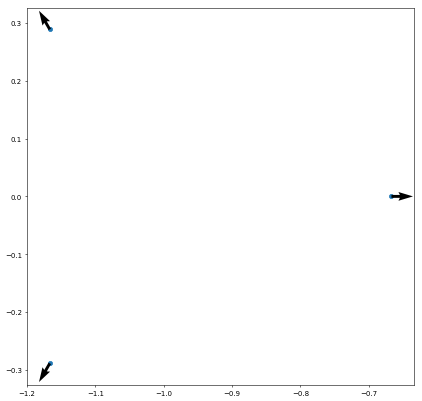

In [7]:
figsize = (10,10)
dpi=(50)
xmin = -4
xmax = 4
ymin = -4
ymax = 4
import matplotlib.pyplot as plt
fig1 = plt.figure(figsize=figsize, dpi=dpi)
plt.scatter(scal.f_support(gd)[:,0], scal.f_support(gd)[:,1])
plt.quiver(scal.f_support(gd)[:,0], scal.f_support(gd)[:,1], scal.f_vectors(gd)[:,0], scal.f_vectors(gd)[:,1])
plt.scatter(gd[:,0], gd[:,1], c='k')
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
plt.show()

def_grid = scal.field_generator()(gridpoints)
plt.figure(figsize=figsize, dpi=dpi)
plt.scatter(gd[:,0], gd[:,1], c='r')
plt.quiver(gridpoints.detach()[:,0], gridpoints.detach()[:,1], def_grid.detach()[:,0], def_grid.detach()[:,1],scale=5)
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.show()


In [ ]:
constr_Id = dm.constraints.Identity_Silent()
comp = dm.deformationmodules.CompoundModule([scal])
mod = dm.multishape.MultiShapeModule([comp], 1.)
H = dm.hamiltonian_multishape.Hamiltonian_multi(mod, constr_Id)
states, controls, grids = dm.shooting.shoot_euler_silent(H, gridpoints, it=10)

grid_final = grids[-1][0]

In [ ]:
H.module.manifold.fill_cotan(torch.ones_like(torch.cat(H.module.manifold.unroll_cotan())))
H.module.manifold.cotan
H.geodesic_controls()

In [ ]:
H.module.controls

In [ ]:
x1, y1 = dm.usefulfunctions.vec2grid(grid_final, nx,ny)

fig_grid1 = mm.plot_grid(x1.detach().numpy(), y1.detach().numpy(), color = 'blue', figsize=figsize, dpi=dpi)
plt.show()

In [ ]:
rot = dm.deformationmodules.LocalRotation(dm.manifold.Landmarks(dim, 1, gd=torch.tensor([0.,0.])), sigma=2.)

In [ ]:
rot.fill_controls(torch.tensor([5.], requires_grad=True))

gd = torch.tensor([0.,0.]).view(-1,2)
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(rot.f_support(gd)[:,0], rot.f_support(gd)[:,1])
plt.quiver(rot.f_support(gd)[:,0], rot.f_support(gd)[:,1], rot.f_vectors(gd)[:,0], rot.f_vectors(gd)[:,1])
plt.scatter(gd[:,0], gd[:,1], c='k')
plt.axis('equal')
plt.show()

def_grid = rot.field_generator()(gridpos)
plt.figure()
plt.scatter(gd[:,0], gd[:,1], c='r')
plt.quiver(gridpos.detach()[:,0], gridpos.detach()[:,1], def_grid.detach()[:,0], def_grid.detach()[:,1])
plt.axis('equal')
plt.show()


In [ ]:
rot(torch.tensor([2.,0.]).view(-1,2))

In [35]:
source = torch.tensor([0.,0.], requires_grad=True).view(-1,2)
sigma_scaling = 1.
dty = torch.float64
a = torch.sqrt(torch.tensor(3.))
direc_scaling_pts = torch.tensor([[1., 0.], [-0.5 , 0.5* a],  [-0.5, -0.5* a]], requires_grad=True, dtype=dty)
direc_scaling_vec =  torch.tensor([[1., 0.], [-0.5 , 0.5* a],  [-0.5, -0.5* a]], requires_grad=True, dtype=dty)
def f(x):
    centre = x.view(1,2).repeat(3,1)
    return centre + 0.3 * sigma_scaling * direc_scaling_pts

def g(x):
    return direc_scaling_vec
#%%
#gd0 = torch.tensor([[-1., 0.6]], requires_grad=True, dtype=dty)
gd0 = torch.tensor([[-1., 0.]], requires_grad=True, dtype=dty)
cotan0 = torch.tensor([[0., 0.]], requires_grad=True, dtype=dty)
#gd1 = torch.tensor([[0.8, 0.6]], requires_grad=True, dtype=dty)
gd1 = torch.tensor([[1., 0.]], requires_grad=True, dtype=dty)
cotan1 = torch.tensor([[0., 0.]], requires_grad=True, dtype=dty)
#%%
pts = f(gd0).detach().numpy()
vec = g(gd0).detach().numpy()
pts1 = f(gd1).detach().numpy()
vec1 = g(gd1).detach().numpy()


plt.quiver(pts[:,0], pts[:,1], vec[:,0], vec[:,1])
plt.quiver(pts1[:,0], pts1[:,1], vec1[:,0], vec1[:,1])
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], 'b')
#plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], 'r')
plt.axis('equal')
#%%
scaling0 = dm.deformationmodules.ConstrainedTranslations(dm.manifold.Landmarks(2, 1, gd = gd0.view(-1), cotan = cotan0.view(-1)), f, g, sigma_scaling)
scaling1 = dm.deformationmodules.ConstrainedTranslations(dm.manifold.Landmarks(2, 1, gd = gd1.view(-1), cotan = cotan1.view(-1)), f, g, sigma_scaling)


In [38]:
scaling0.manifold.gd, scaling0.manifold.cotan, scaling0.controls

(tensor([-1.,  0.], grad_fn=<ViewBackward>),
 tensor([0., 0.], grad_fn=<ViewBackward>),
 tensor([0.], requires_grad=True))

In [44]:
scaling0.manifold.fill_cotan(torch.tensor([0.,-1.], requires_grad=True).view(-1))
scaling0.compute_geodesic_control(scaling0.manifold.copy())
scaling0.controls

tensor(2.2204e-16, grad_fn=<MulBackward0>)

In [53]:
nb_pts1 = 7
dim = 2

o1 = torch.tensor([-1.,0.])
o2 = torch.tensor([-1.,0.])
origin = [o1,o2]
r1 = 2
r2 = 1
radius = [r1, r2]
nb_pts = [nb_pts1, nb_pts1]
source = mm.multipleCircles(origin, radius, nb_pts)

# Visualization of grid deformation for each submodule
xmin = -5
xmax = 5
ymin = -5
ymax = 5
dx = 0.2
dy = 0.2
nx = int((xmax-xmin)/dx)
ny = int((ymax-ymin)/dy)
x,y,gridpoints = mm.gridpoints(xmin, xmax, ymin, ymax, dx, dy)


gd = gridpoints
man_silent = dm.manifold.Landmarks(2,len(gridpoints), gd=gridpoints.view(-1))
silent = dm.deformationmodules.SilentPoints(man_silent)

comp = dm.deformationmodules.CompoundModule([silent, scaling0])

In [54]:
H = dm.hamiltonian.Hamiltonian([comp])
states, controls = dm.shooting.shoot_euler(H, it=10)


In [59]:
states[-1].gd[0]

tensor([-5.0000, -5.0000, -5.0000,  ...,  4.6000,  4.8000,  4.8000],
       requires_grad=True)

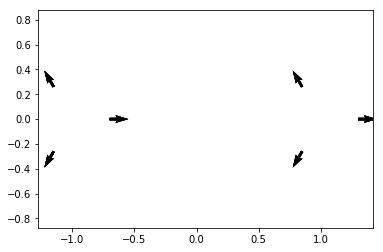

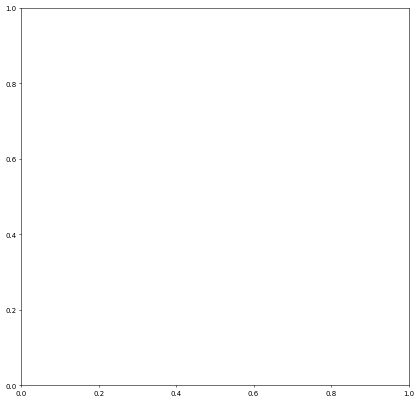

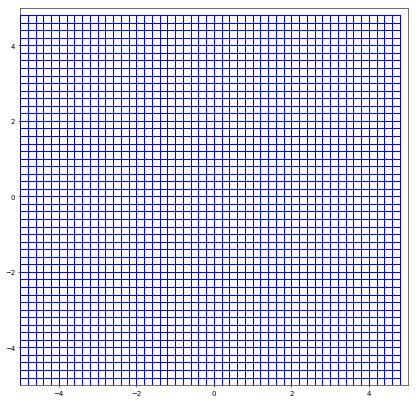

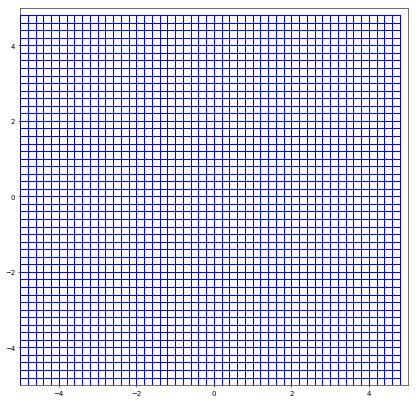

In [61]:
x1, y1 = dm.usefulfunctions.vec2grid(states[-1].gd[0].view(-1,2), nx,ny)

fig_grid1 = mm.plot_grid(x1.detach().numpy(), y1.detach().numpy(), color = 'blue', xlim=[-5,5], ylim=[-5,5], figsize=figsize, dpi=dpi)
plt.show()

In [52]:
scaling0.field_generator()(gd)

tensor([[ 3.1064e-17,  0.0000e+00],
        [ 1.5941e-17,  1.7231e-17],
        [-9.5995e-18,  2.8115e-17],
        [-2.1873e-17,  1.4825e-17],
        [-2.1873e-17, -1.4825e-17],
        [-9.5995e-18, -2.8115e-17],
        [ 1.5941e-17, -1.7231e-17]], grad_fn=<AsStridedBackward>)

In [37]:
figsize = (10,10)
dpi=(50)
xmin = -4
xmax = 4
ymin = -4
ymax = 4

support_generator = f
vector_generator = g
import matplotlib.pyplot as plt
fig1 = plt.figure(figsize=figsize, dpi=dpi)
plt.scatter(support_generator(gd)[:,0], support_generator(gd)[:,1])
plt.quiver(support_generator(gd)[:,0], support_generator(gd)[:,1], vector_generator(gd)[:,0], vector_generator(gd)[:,1])
plt.scatter(gd[:,0], gd[:,1], c='k')
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
plt.show()

def_grid = scaling0.field_generator()(gridpoints)
plt.figure(figsize=figsize, dpi=dpi)
plt.scatter(gd[:,0], gd[:,1], c='r')
plt.quiver(gridpoints.detach()[:,0], gridpoints.detach()[:,1], def_grid.detach()[:,0], def_grid.detach()[:,1],scale=5)
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.show()


RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

In [ ]:
def test_gradcheck_autoaction():
    def autoaction(mom):
        #scal.manifold.fill_gd(scal.manifold.roll_gd([gd]))
        scal.manifold.fill_cotan(scal.manifold.roll_cotan([mom]))

        return scal.autoaction()


    gd = scal.manifold.unroll_gd()
    mom = scal.manifold.unroll_cotan()

    return torch.autograd.gradcheck(autoaction, (mom), raise_exception=True)


test_gradcheck_autoaction()

In [ ]:
def test_gradcheck_geo_cont():
    def autoaction(mom):
        #scal.manifold.fill_gd(scal.manifold.roll_gd([gd]))
        scal.manifold.fill_cotan(scal.manifold.roll_cotan([mom]))
        scal.compute_geodesic_control(scal.manifold)
        return scal.controls


    gd = scal.manifold.unroll_gd()
    mom = scal.manifold.unroll_cotan()

    return torch.autograd.gradcheck(autoaction, (mom), raise_exception=True)


test_gradcheck_geo_cont()